# Jordan Red Wine Quality Ensemble Models
**Author:** Jordan  
**Date:** November 21, 2025 <br>
**Objective:** Train and evaluate Gradient Boosting and AdaBoost endsemble models.


## Introduction
In this project, we use the UCI Red Wine Quality dataset. We will preprocess the data and train Gradient Boosting and AdaBoost classifier ensemble models using features based on physicochemical tests to predict the wine quality rating given by wine tasters.  Then, we will give comparisons of the models to each other and the models obtained from other team members.

## Imports
First, we import the necessary Python libraries for our analysis. 

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

## Section 1. Load and Inspect the Data

Next, we load the Wine Quality dataset into a dataframe and call the .info() and .head() methods to view the structure and initial rows of our data.

In [58]:
df = pd.read_csv("winequality-red.csv", sep=";")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Section 2. Prepare the Data

Now, we prepare our target feature for classification by creating the columns 'quality_label' and 'quality_numeric'.  We bin the continuous 'quality' feature based on its range and then numerically store the values in the 'quality_numeric' column so our ensemble models predict on them properly.

In [59]:
def quality_to_label(q):  # noqa: D103
    if q <= 4:
        return "low"
    if q <= 6:
        return "medium"
    return "high"

def quality_to_number(q):  # noqa: D103
    if q <= 4:
        return 0
    if q <= 6:
        return 1
    return 2

df["quality_label"] = df["quality"].apply(quality_to_label)
df["quality_numeric"] = df["quality"].apply(quality_to_number)

## Section 3. Feature Selection and Justification

With classification in mind, we now separate our data into input features X and our target variable y.  The target for prediction will be the numerically binned 'quality_numeric' column and all other physicochemical columns in the dataframe we will use as predicting features.

In [60]:
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])  # Features
y = df["quality_numeric"]  # Target

## Section 4. Split the Data into Train and Test

Now, we split our target variable and feature sets into training and testing sets with a stratified split to preserve target feature class balance.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Section 5. Evaluate Model Performance

At this stage, we train our Gradient Boosting and AdaBoost classifier ensemble models on the training sets.  Then, we evaluate their performance on both training and testing sets to check for underfitting and overfitiing.

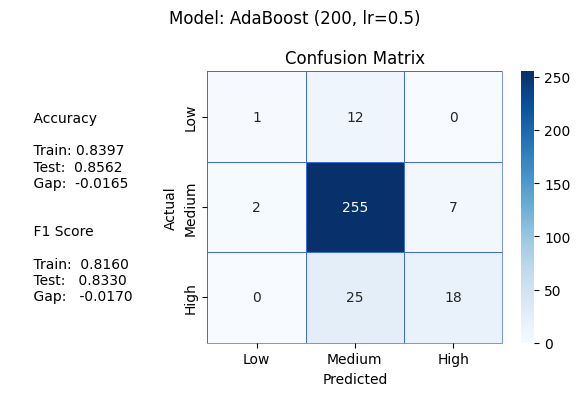

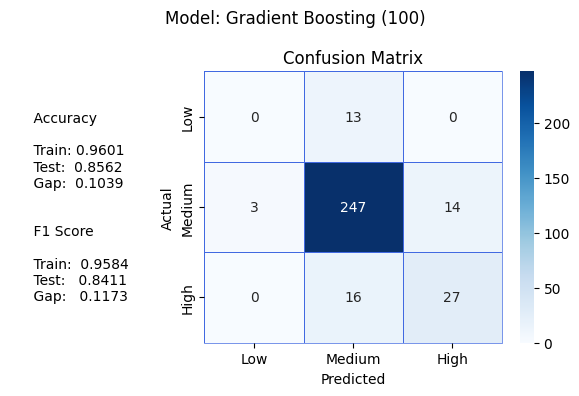

In [62]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):  # noqa: D103, N803
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    acc_gap = train_acc - test_acc
    f1_gap = train_f1 - test_f1

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Accuracy Gap": acc_gap,
            "Train F1": train_f1,
            "Test F1": test_f1,
            "F1 Gap": f1_gap
        }
    )

    results_text: str = f"""
    Accuracy

    Train: {train_acc:.4f}
    Test:  {test_acc:.4f}
    Gap:  {acc_gap:.4f}


    F1 Score

    Train:  {train_f1:.4f}
    Test:   {test_f1:.4f}
    Gap:   {f1_gap:.4f}
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,4), gridspec_kw={"width_ratios": [1,3]})

    axes[0].text(0.05, 0.5, results_text,
                 ha="left", va="center")
    axes[0].axis("off")

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", ax=axes[1],
                linewidths=.5, linecolor="royalblue", fmt="d")
    axes[1].patch.set_edgecolor("royalblue")
    axes[1].patch.set_linewidth(0.5)
    axes[1].set(xlabel="Predicted", ylabel="Actual", title="Confusion Matrix")
    axes[1].set_xticklabels(["Low", "Medium", "High"])
    axes[1].set_yticklabels(["Low", "Medium", "High"])

    fig.suptitle(f"Model: {name}")
    plt.tight_layout()
    plt.show()

results: list = []

# 4. AdaBoost (200, lr=0.5)
evaluate_model(
    "AdaBoost (200, lr=0.5)",
    AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)
# 5. Gradient Boosting
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

Now, we use GridSearchCV to tune hyperparameters for our Gradient Boosting model.

Starting Grid Search for Gradient Boosting...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Grid Search complete.
Best parameters found: {'learning_rate': 0.15, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 250, 'subsample': 0.8}
Best F1 Score (CV): 0.8275


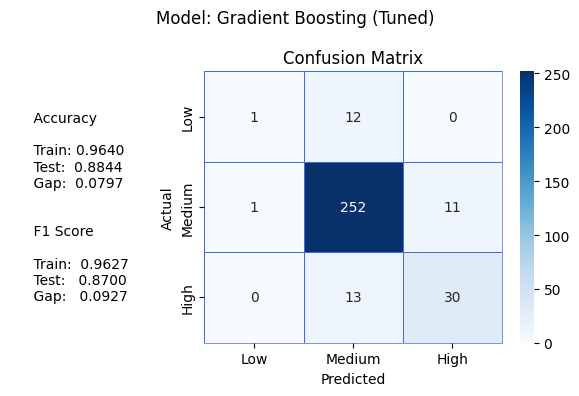

In [63]:
# Define 5-fold stratified cross-validator for tuning both our models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_model = GradientBoostingClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    "n_estimators": [100, 150, 200, 250],    # Various amount of trees
    "learning_rate": [0.05, 0.1, 0.15],      # Various learning rates
    "max_depth": [1, 2],                     # Various tree depths
    "subsample": [0.7, 0.8, 0.9],            # Various forced subsampling
    "max_features": ["sqrt"]                 # Restrict number of features at each tree split
}

grid_search = GridSearchCV(
    estimator=gb_model,        # The model we are tuning
    param_grid=param_grid,     # The grid of parameters to test
    scoring="f1_weighted",     # The metric to optimize
    cv=skf,                    # Cross-validation strategy
    verbose=1,                 # Print progress updates during search
    n_jobs=-1                  # Use all available CPU cores
)

print("Starting Grid Search for Gradient Boosting...")
grid_search.fit(X_train, y_train)
print("Grid Search complete.")

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 Score (CV): {grid_search.best_score_:.4f}")

best_gb_model = grid_search.best_estimator_

# Calling evaluate_model here will append the results of the "best" model to our results list
evaluate_model(
    "Gradient Boosting (Tuned)",
    best_gb_model,
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

Finally, we use GridSearchCV to tune hyperparameters for our AdaBoost model.

Starting Grid Search for AdaBoost Classifier...
Fitting 5 folds for each of 195 candidates, totalling 975 fits
Grid Search complete.
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200}
Best F1 Score (CV): 0.8374


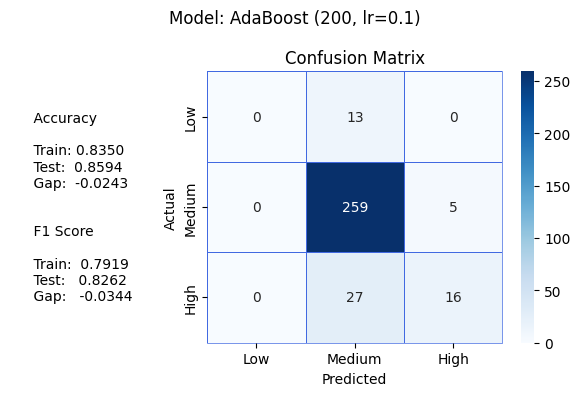

In [64]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    "n_estimators": [100, 150, 200, 250, 300],
    "learning_rate": np.arange(0.05, 2.0, 0.05).tolist()  # Learning rates from 0.05 to 2.0 by 0.05
}

ab_grid_search = GridSearchCV(
    estimator=ab_model,
    param_grid=ab_param_grid,
    scoring="accuracy",
    cv=skf,
    verbose=1,
    n_jobs=-1
)

print("Starting Grid Search for AdaBoost Classifier...")
ab_grid_search.fit(X_train, y_train)
print("Grid Search complete.")

print(f"Best parameters found: {ab_grid_search.best_params_}")
print(f"Best F1 Score (CV): {ab_grid_search.best_score_:.4f}")

best_ab_model = ab_grid_search.best_estimator_
ab_lr, ab_est = ab_grid_search.best_params_.values()

# Calling evaluate_model here will append the results of the "best" model to our results list
evaluate_model(
    f"AdaBoost ({ab_est}, lr={ab_lr})",
    best_ab_model,
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

## Section 6. Compare Results

In this section, we compare the results of our Gradient Boosting and AdaBoost models.


In [65]:
# Define a dataframe for the results and sort on 'Test Accuracy' then 'Accuracy Gap'
results_df = pd.DataFrame(results).sort_values(by=["Test Accuracy", "Accuracy Gap"],
                                               ascending=[False, True])

print("\nSummary of All Models:")
# Round the results, reset index to denote top accuracy, and then display the dataframe
display(results_df.round(4).reset_index(drop=True))


Summary of All Models:


,Model,Train Accuracy,Test Accuracy,Accuracy Gap,Train F1,Test F1,F1 Gap
0,Gradient Boosting (Tuned),0.9640,0.8844,0.0797,0.9627,0.8700,0.0927
1,"AdaBoost (200, lr=0.1)",0.8350,0.8594,-0.0243,0.7919,0.8262,-0.0344
2,"AdaBoost (200, lr=0.5)",0.8397,0.8562,-0.0165,0.8160,0.8330,-0.0170
3,Gradient Boosting (100),0.9601,0.8562,0.1039,0.9584,0.8411,0.1173


## Section 7. Conclusions and Insights

| Model                     |   Train Accuracy |   Test Accuracy |   Accuracy Gap |   Train F1 |   Test F1 |   F1 Gap |
|:--------------------------|-----------------:|----------------:|---------------:|-----------:|----------:|---------:|
| Gradient Boosting (Tuned) |           0.964  |          0.8844 |         0.0797 |     0.9627 |    0.87   |   0.0927 |
| AdaBoost (200, lr=0.1)    |           0.835  |          0.8594 |        -0.0243 |     0.7919 |    0.8262 |  -0.0344 |
| AdaBoost (200, lr=0.5)    |           0.8397 |          0.8562 |        -0.0165 |     0.816  |    0.833  |  -0.017  |
| Gradient Boosting (100)   |           0.9601 |          0.8562 |         0.1039 |     0.9584 |    0.8411 |   0.1173 |

Based upon our model summary, the AdaBoost models are significantly more robust than the Gradient Boosting models. This is indicated by the AdaBoost models' negative accuracy and F1 score gaps, compared to the Gradient Boosting models' gaps of over 7.9 percentage points, which demonstrates significant overfitting.

To compare our results to the models obtained by the team thus far, we view the table from analyst Daniel Miller's report found [here](https://github.com/DMill31/applied-ml-miller/blob/main/notebooks/project05/ensemble-miller.ipynb).

| Model                | Train Accuracy | Test Accuracy | Train F1 | Test F1 | Accuracy Gap | F1 Gap |
| :---------------:    | -------------: | ------------: | -------: | ------: | -----------: | -----: |
| Bagging              | 1.0            | 0.884         | 1.0      | 0.865   | 0.116        | 0.135  |
| Random Forest        | 1.0            | 0.888         | 1.0      | 0.866   | 0.113        | 0.134  |
| Voting(DT + SVM + NN)| 0.928          | 0.850         | 0.912    | 0.832   | 0.078        | 0.079  |

Based upon the team model summary, we observe that the Bagging and Random Forest models are showing significant overfitting with accuracy and F1 score gaps of above 10 percentage points.  The Voting Decision Tree, State Vector Machine, and Neural Network model also shows signs of overfitting with accuracy and F1 score gaps of approximately 8 percentage points.  The Voting model is not overfitting to the extent of the Bagging or Random Forest, but it is less robust than the AdaBoost model.  Thus, since the AdaBoost models' test accuracy is within 3 percentage points of the highest test accuracy, it is performing the best out of the models tested so far.  

In regards to building a predictor for a competition, based on the results so far, I would first attempt hyperparameter tuning on the Random Forest model.  The model demonstrated peak test accuracy out of all the models, but showed significant overfitting.  To address the overfitting, I would run GridSearchCV for the Random Forest classifier over various max_depth and min_samples_leaf values lower than the default value to limit the complexity of the individual decision trees and possibly improve robustness.

Another possibility for a competition model would be that of Gradient Boosting, whose test accuracy was second to Random Forest at 88.4 percent.  The tuned Gradient Boosting model responded well to limiting the number of features for each split with the max_features="sqrt" parameter.  This response indicates that further dimensionality reduction, such as with Principal Component Analysis, could possibly eliminate some of the noise in the data, reducing the overfitting and producing a more robust model.